<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import random

In [2]:
class SVM:
    def __init__(self, C, tolerance, epsilon, max_step, kernel, sigma = 0.5):
        self.C = C # 参数 C
        self.tolerance = tolerance # 容错率
        self.epsilon = epsilon # 拉格朗日乘数更新的最小比率
        self.max_step = max_step # 训练次数
        self.kernel = kernel # 核函数类型： 'linear'、 'rbf'
        self.sigma = sigma
    
    # 定义核函数
    #sample：单样本，行向量
    def Kernel(self, X, sample):
        if self.kernel == 'linear': # 线性核函数
            result = np.dot(X, sample.T).reshape(-1, 1)
        elif self.kernel == 'rbf': # 高斯核函数
            result = np.exp(-np.linalg.norm(X - sample, ord = 2, axis = 1,
                                            keepdims = True)**2 / (2*self.sigma**2))
        else:
            result = None
            print('Non-legal kernel')
        return result
    
    # 计算 Gram 矩阵
    def Gram(self, X):
        self.K = np.zeros((self.N, self.N))
        for i, x in enumerate(X):
            self.K[i, :] = self.Kernel(X, x).reshape(1, -1)
            
    # 更新 alpha1、 alpha2、 b、 E
    # 返回：成功更新， True；否则， False
    def update(self, index1, index2, X, Y):
        if (index1 == index2): # 两个相同的拉格朗日乘数，无更新必要
            return False
        # 取出乘数 alpha
        alpha1 = self.alpha[index1][0]
        alpha2 = self.alpha[index2][0]
        # 取出输入向量
        x1 = X[index1].reshape(-1, 1)
        x2 = X[index2].reshape(-1, 1)
        # 取出标签
        y1 = Y[index1][0]
        y2 = Y[index2][0]
        # 取出 E
        E1 = self.E[index1][0]
        E2 = self.E[index2][0]
        # 计算 alpha 的上界 H 与下界 L
        if (y1 == y2):
            L = max(0, alpha2 + alpha1 - self.C)
            H = min(self.C, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        if (L == H): # 相同的下界与上界，无更新必要
            return False
        # 计算 eta
        k11 = self.K[index1, index1]
        k22 = self.K[index2, index2]
        k12 = self.K[index1, index2]
        eta = k11 + k22 - 2 * k12
        if eta <= 0: # 不更新
            return False
        alpha2_new = alpha2 + y2 * (E1 - E2) / eta # 计算 alpha2 的新值
        alpha2_new = min(max(alpha2_new, L), H) # 对 alpha2 进行 [L, H] 裁剪
        if abs(alpha2_new - alpha2) < self.epsilon * (alpha2_new + alpha2 + self.epsilon): # 无更新必要
            return False
        alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new) # 计算 alpha1 的新值
        # 计算 b1 和 b2，并且更新 b
        b1 = -E1 - y1 * k11 * (alpha1_new - alpha1) - y2 * k12 * (alpha2_new - alpha2) + self.b
        b2 = -E2 - y1 * k12 * (alpha1_new - alpha1) - y2 * k22 * (alpha2_new - alpha2) + self.b
        if alpha1_new > 0 and alpha1_new < self.C:
            self.b = b1
        elif alpha2_new > 0 and alpha2_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        # 保存 alpha1_new 和 alpha2_new，并确保约束 >=0
        self.alpha[index1][0] = max(0, alpha1_new)
        self.alpha[index2][0] = max(0, alpha2_new)
        # 更新 E
        self.E = np.dot((self.alpha * Y).T, self.K).reshape(-1, 1) + self.b - Y
        return True
    
    # 找出最佳的 2 个样本点，并启动更新
    #index：给定的第 2 个样本点索引
    def MatchTwoSamples(self, index, X, Y):
        y2 = Y[index][0]
        alpha2 = self.alpha[index][0]
        E2 = self.E[index][0]
        # 容忍度： E*y=(g(x)-y)y=g(x)y-y^2=g(x)y-1， g(x) 是 y 的实际输出值，
        # 两者越相似越好，此时 tol 接近 0
        tol = E2 * y2
        if ((tol < -self.tolerance and alpha2 < self.C) or 
            (tol > self.tolerance and alpha2 > 0)): # 不符合 KKT 条件，需调整
        # 采取启发式方法，确定另一个乘数 alpha1，找出满足 0<alpha1<C 的点
            list1 = np.nonzero(self.alpha)[0].tolist() # 找出所有非 0 的 alpha（索引）
            # 找出所有非 C 的 alpha（索引）
            list2 = np.nonzero(self.alpha - self.C)[0].tolist()
            result = list(set(list1) & set(list2))
            if len(result) > 1: # 至少有 2 个及以上的候选点，选择一个最好的
                max_diff = -1
                max_index = -1
                for k in result:
                    diff = abs(self.E[k][0] - E2)
                    if diff > max_diff:
                        max_diff = diff
                        max_index = k
                if self.update(max_index, index, X, Y): # 更新这 2 个乘数
                    return True
                # 如果没有成功更新，则随机产生一个位置，逐个尝试每个乘数
                random_index = random.randint(0, len(result)-1)
                for k in range(random_index, len(result)):
                    if self.update(k, index, X, Y): # 更新这 2 个乘数
                        return True
                for k in range(0, random_index):
                    if self.update(k, index, X, Y): # 更新这 2 个乘数
                        return True
            # 从所有可能的乘数中，随机选择一个
            random_index = random.randint(0, self.N-1)
            if self.update(random_index, index, X, Y): # 更新这 2 个乘数
                return True
        return False
    
    def fit(self, X, Y):
        self.X = X # 在使用核函数的情况下，需要保存数据集
        self.Y = Y
        self.N = len(X)
        self.b = 0
        self.alpha = np.zeros((self.N, 1))
        self.Gram(X) # 计算 Gram 矩阵
        # 初始化 E
        self.E = np.dot((self.alpha * Y).T, self.K).reshape(-1, 1) + self.b - Y
        # 开始训练
        self.paras = [] # 存放中间权值的结果，用于生成动画
        for step in range(self.max_step):
            numChanged = 0
            everyone = True # 确保第一次要全局遍历
            while numChanged > 0 or everyone:
                numChanged = 0
                if everyone:
                    for k in range(self.N):
                        numChanged += self.MatchTwoSamples(k, X, Y)
                        if self.kernel == 'linear':
                            # 保存权值
                            self.paras.append((self.b, *np.dot(X.T, (self.alpha * Y)).reshape(1, -1).tolist()))
                        else: # 其它的核函数
                            # 在使用其它核函数的情况下，只能保存每个样本对应的乘数
                            self.paras.append((self.b, self.alpha))
                else:
                    for k in range(self.N):
                        if self.alpha[k] == 0 or self.alpha[k] == self.C:
                            continue
                        numChanged += self.MatchTwoSamples(k, X, Y)
                        if self.kernel == 'linear':
                                # 保存权值
                            self.paras.append((self.b, *np.dot(X.T, (self.alpha * Y)).reshape(1, -1).tolist())) 
                        else: # 其它的核函数
                                # 在使用其它核函数的情况下，只能保存每个样本对应的乘数
                            self.paras.append((self.b, self.alpha))
                if everyone:
                    everyone = False
                elif numChanged == 0:
                    everyone = True
        if self.kernel == 'linear': # 计算 W
            self.W = np.dot(X.T, (self.alpha * Y))
            print(self.b, self.W)
        print('SVM training completed!')
        
    def predict(self, X):
        result = []
        for x in X:
            z = np.dot((self.alpha * self.Y).T, self.Kernel(self.X, x)) + self.b
            result.append(1 if z >= 0 else -1)
        return result

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']
# 转换成适合 SVM 处理的标签
Y[:50] = 1
Y[50:] = -1

In [5]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y, test_size = 0.25)

In [6]:
svm = SVM(1.0, 0.001, 0.01, 2, 'linear')
svm.fit(XTRAIN, YTRAIN.reshape(-1, 1))

3.8432842556708406 [[-1.9952872]
 [ 2.2446981]]
SVM training completed!


In [7]:
XSAMPLES = np.array([(5.5, 2.8), (5.5, 4.0), (4.5, 3.5), (6.5, 2.5)])
results = svm.predict(XSAMPLES)
print(results)

[-1, 1, 1, -1]


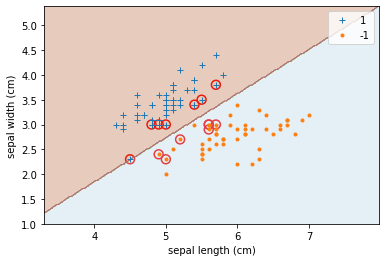

In [8]:
plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')
# 绘制支持向量
for k, alpha in enumerate(svm.alpha):
    if alpha > 0.1:
        plt.scatter(XTRAIN[k][0], XTRAIN[k][1], s = 80, c = 'none',
        linewidth=1.5, edgecolor = 'red')
# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),np.arange(x1_min, x1_max, 0.02))
z = np.array(svm.predict(np.c_[xx0.ravel(), xx1.ravel()]))
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.3)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

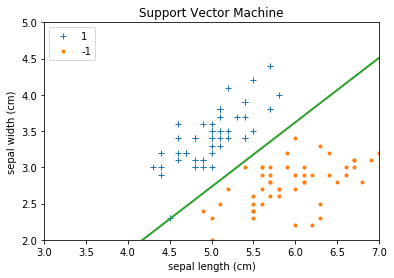

In [9]:
import matplotlib.animation as animation
from IPython.display import HTML
# 动画播放，如果是%matplotlib inline，则会嵌入图片
%matplotlib inline
fig = plt.figure()
ax = plt.axes(xlim=(3, 7), ylim=(2, 5))
ax.plot(data[:50, 0], data[:50, 1], '+', label='1')
ax.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.set_title('Support Vector Machine')
ax.legend(loc = 'upper left')
line, = ax.plot([], [], lw = 2)

def update(para):
    b = para[0]
    W0 = para[1][0]
    W1 = para[1][1]
    if W1 == 0:
        return
    X_points = np.linspace(4, 7,10)
    Y_points = -(W0 * X_points + b)/W1
    line.set_data(X_points, Y_points)
ani = animation.FuncAnimation(fig, update, svm.paras)

HTML(ani.to_html5_video())
ani.save('SVM_Fitting.mp4')

In [10]:
from collections import Counter

results = svm.predict(XTEST)
scores = (results == YTEST)
scores = [score for score in scores]
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Accuracy = 100.00%


In [11]:
svm = SVM(1.0, 0.001, 0.01, 2, 'rbf', sigma = 1.0)
svm.fit(XTRAIN, YTRAIN.reshape(-1,1))

SVM training completed!


In [12]:
XSAMPLES = np.array([(5.5, 2.8), (5.5, 4.0), (4.5, 3.5), (6.5, 2.5)])
results = svm.predict(XSAMPLES)
print(results)

[-1, 1, 1, -1]


In [13]:
results = svm.predict(XTEST)
scores = (results == YTEST)
scores = [score for score in scores]
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Accuracy = 100.00%


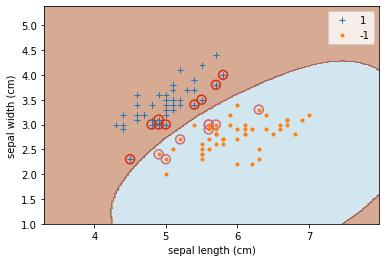

In [14]:
%matplotlib inline
plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')
# 绘制支持向量
for k, alpha in enumerate(svm.alpha):
    if alpha > 0.1:
        plt.scatter(XTRAIN[k][0], XTRAIN[k][1], s = 80, c = 'none', linewidth=1.5, edgecolor = 'red')
# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02), np.arange(x1_min, x1_max, 0.02))
z = np.array(svm.predict(np.c_[xx0.ravel(), xx1.ravel()]))
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.5)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.xlim(xx0.min(), xx0.max())
plt.ylim(xx1.min(), xx1.max())
plt.legend()

In [15]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
clf.fit(XTRAIN, YTRAIN)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',max_iter=-1, probability=False, random_state=None, shrinking=True,tol=0.001, verbose=False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [16]:
print(clf.coef_, clf.intercept_)

[[-2.00182665  2.26751432]] [3.7938533]


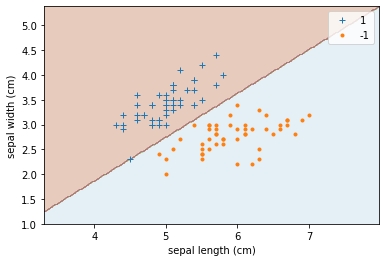

In [17]:
%matplotlib inline
plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')
# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),np.arange(x1_min, x1_max, 0.02))
z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.3)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

In [18]:
clf.score(XTEST, YTEST)

1.0

In [19]:
clf = SVC(kernel = 'rbf')
clf.fit(XTRAIN, YTRAIN)

D:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

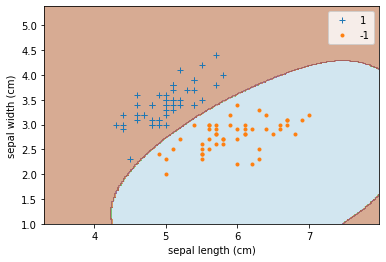

In [20]:
%matplotlib inline
plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')
# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
np.arange(x1_min, x1_max, 0.02))
z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.5)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()